In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import jax
import jax.numpy as jnp

import numpy as np
from tqdm import tqdm

from src.sampler_jax import hmc, hamiltonian_side_move, hamiltonian_walk_move
from src.visualize.corner import corner

In [3]:
# Distribution
dim = 3
true_mean = np.zeros(dim)
precision_matrix = np.eye(dim)

def potential(x):
    """Vectorized negative log density (potential energy)"""        
    # Vectorized operation for all samples
    centered = x - true_mean
    result = 0.5 * jnp.einsum('j,jk,k->', centered, precision_matrix, centered)
        
    return result

# Sampler setup
initial = jnp.zeros(dim)

n_samples = 10**5
burn_in = 10**4


# HMC

In [147]:
samples, acceptance_rates = hmc(potential, 
                                initial, 
                                n_samples,
                                n_chains=3,
                                epsilon=0.1, 
                                L=10, 
                                n_thin=1,
                                key=jax.random.PRNGKey(1))
samples = samples.reshape(-1, dim)[burn_in:]

[0.99877 0.9988  0.99865]


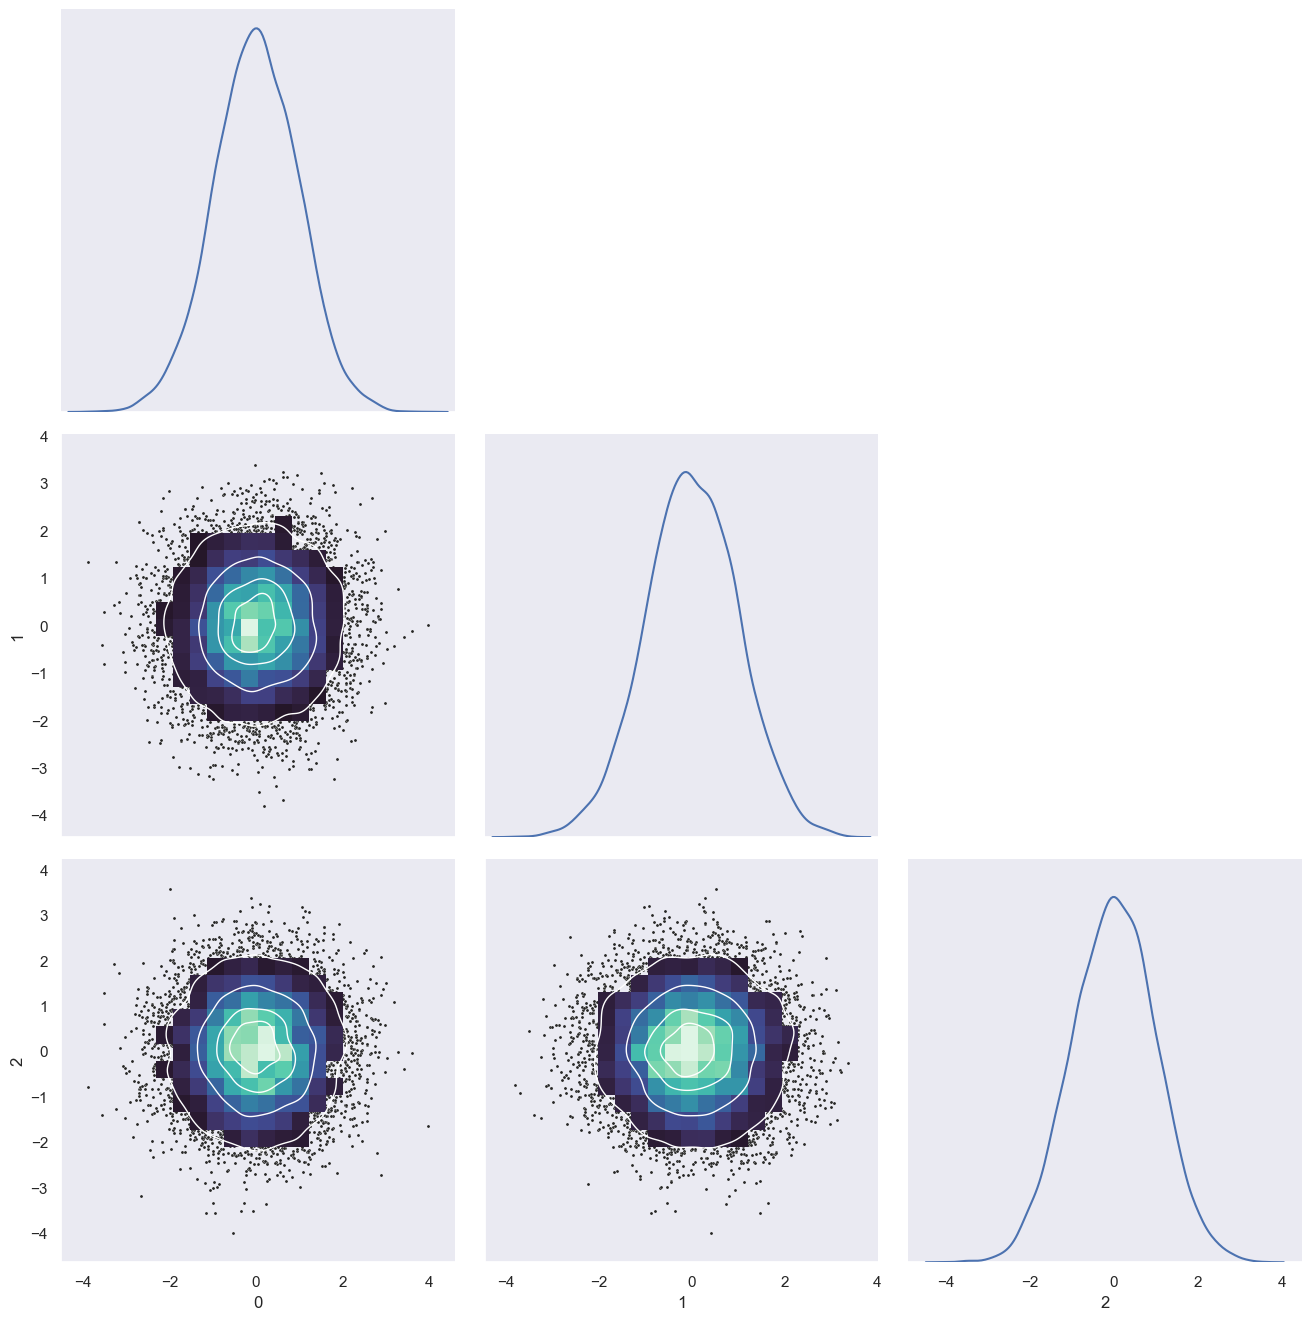

In [145]:
print(acceptance_rates)
corner(samples[-10000:])

# HMC Side Move

In [148]:
samples, acceptance_rates = hamiltonian_side_move(potential, 
                                                  initial, 
                                                  n_samples, 
                                                  n_chains_per_group=5, 
                                                  epsilon=0.1, 
                                                  L=10, 
                                                  beta=1.0, 
                                                  n_thin=1)
samples = samples.reshape(-1, dim)[burn_in:]

0.99966


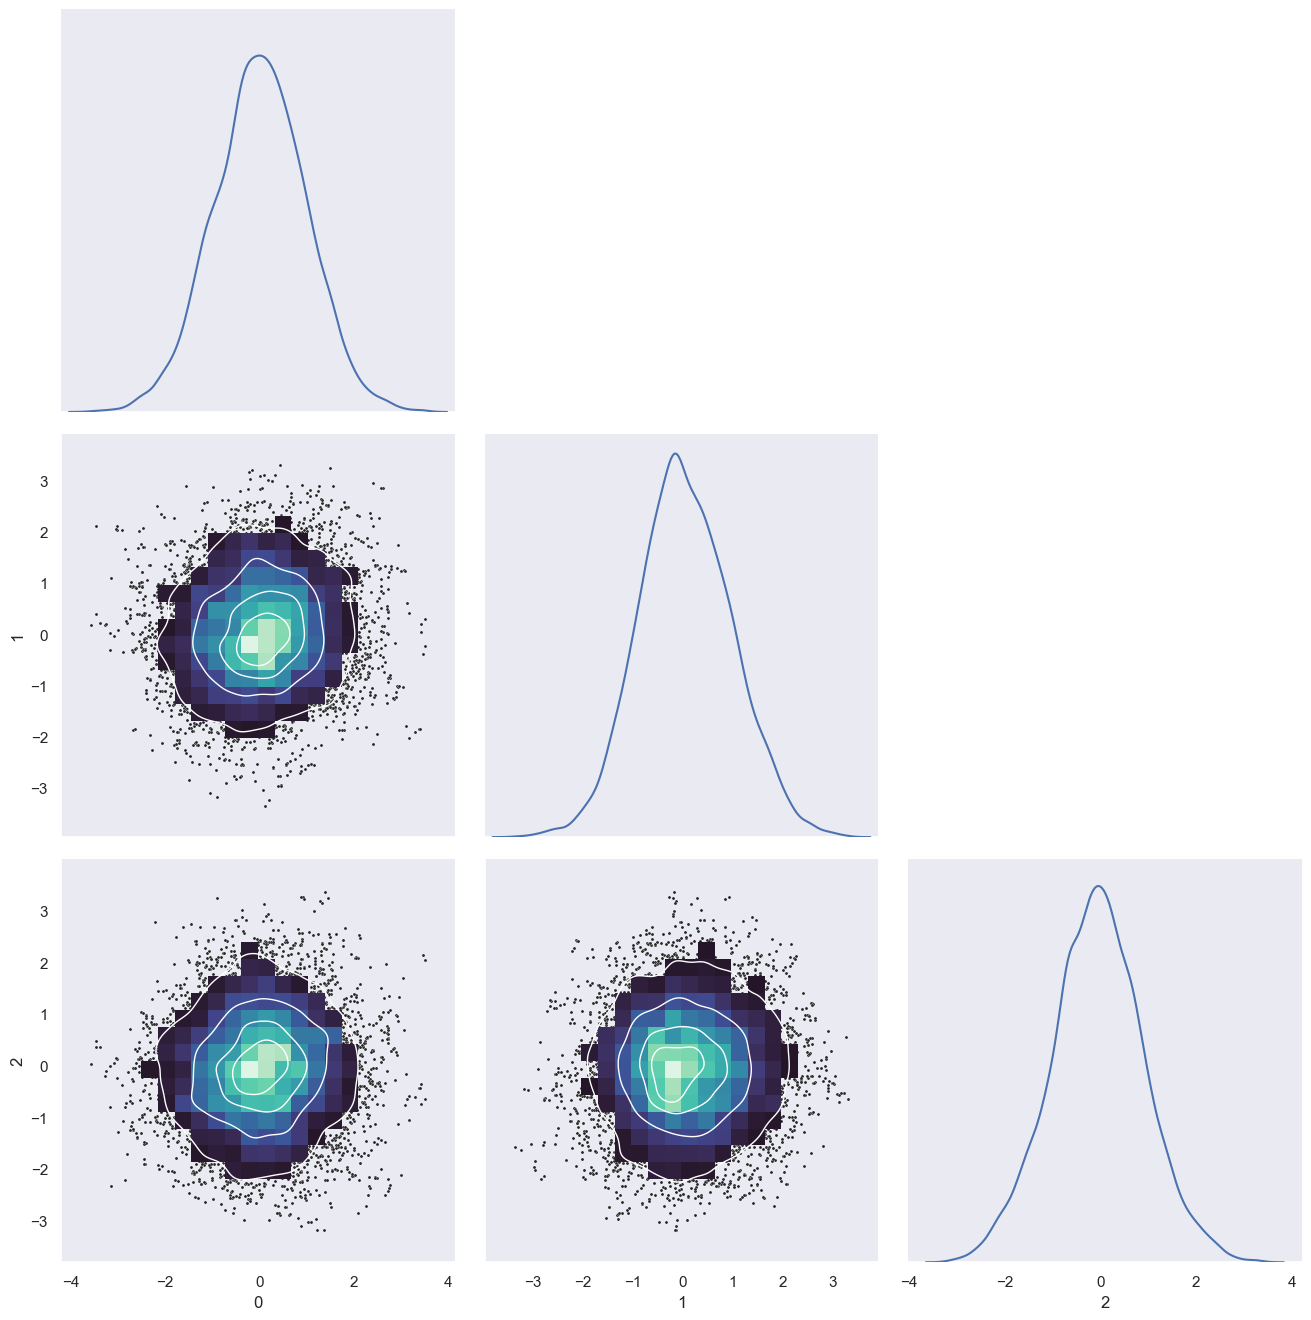

In [143]:
print(acceptance_rates)
corner(samples[-10000:,:])

# HMC Walk Move

In [48]:
samples, acceptance_rates = hamiltonian_walk_move(potential, 
                                                  initial, 
                                                  n_samples, 
                                                  n_chains_per_group=5, 
                                                  epsilon=0.1, 
                                                  L=10, 
                                                  beta=1.0,
                                                  n_thin=1)
samples = samples.reshape(-1, dim)[burn_in:]

In [ ]:
print(acceptance_rates)
corner(samples[-10000:])

[0.82565 0.8241  0.82443 0.82152 0.82615 0.82288 0.8251  0.82487 0.82461
 0.82437]


# Testing

In [31]:
def hamiltonian_walk_move(gradient_func, potential_func, initial, n_samples, n_chains_per_group=5, 
                       epsilon=0.01, n_leapfrog=10, beta=0.05, n_thin = 1):
    """
    Vectorized Hamiltonian Walk Move sampler.
    n_thin : int
        Thinning factor - store every n_thin sample (default: 1, no thinning)
    """
    
    # Initialize
    orig_dim = initial.shape
    flat_dim = np.prod(orig_dim)
    total_chains = 2 * n_chains_per_group
    
    # Create initial states with small random perturbations
    states = np.tile(initial.flatten(), (total_chains, 1)) + 0.1 * np.random.randn(total_chains, flat_dim)
    
    # Split into two groups
    group1 = slice(0, n_chains_per_group)
    group2 = slice(n_chains_per_group, total_chains)
    
    # Calculate total iterations needed based on thinning factor
    total_iterations = n_samples * n_thin
    
    # Storage for samples and acceptance tracking
    samples = np.zeros((total_chains, n_samples, flat_dim))
    accepts = np.zeros(total_chains)
    
    # Sample index to track where to store thinned samples
    sample_idx = 0
    
    # Precompute some constants for efficiency
    beta_eps = beta * epsilon
    beta_eps_half = beta_eps / 2
    
    # Main sampling loop
    for i in range(total_iterations):
        # Store current state from all chains (only every n_thin iterations)
        if i % n_thin == 0 and sample_idx < n_samples:
            samples[:, sample_idx] = states
            sample_idx += 1
        
        # Compute centered ensembles for preconditioning
        centered2 = (states[group2] - np.mean(states[group2], axis=0)) / np.sqrt(n_chains_per_group)
        
        # First group update
        # Generate momentum - fully vectorized with correct dimensions
        p1 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        # Store current state and energy
        current_q1 = states[group1].copy()
        current_q1_reshaped = current_q1.reshape(n_chains_per_group, *orig_dim)
        current_U1 = potential_func(current_q1_reshaped)
        current_K1 =  np.clip(0.5 *np.sum(p1**2, axis=1), 0, 1000)
        
        # Leapfrog integration with preconditioning
        q1 = current_q1.copy()
        p1_current = p1.copy()
        
        # Initial half-step for momentum - vectorized
        grad1 = gradient_func(q1.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
        # Handle NaNs safely
        grad1 = np.nan_to_num(grad1, nan=0.0)
        
        # Matrix multiplication for projection - fully vectorized
        print(grad1.shape) # Prints (5, 3)
        print(centered2.shape) # Prints (5, 3)
        print(p1_current.shape) # Prints (5, 5)
        p1_current = p1_current - beta_eps_half * np.einsum('ik,jk->ij', grad1, centered2)

        
        # Full leapfrog steps
        # n_steps = np.random.randint(n_leapfrog//2, 2*n_leapfrog)
        n_steps = n_leapfrog
        for step in range(n_steps):
            # Full position step - vectorized matrix multiplication
            q1 += beta_eps * np.dot(p1_current, centered2)
            
            if step < n_steps - 1:
                # Full momentum step (except at last iteration) - vectorized
                grad1 = gradient_func(q1.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
                # Handle NaNs safely
                grad1 = np.nan_to_num(grad1, nan=0.0)
                
                p1_current -= beta_eps * np.dot(grad1, centered2.T)
        
        # Final half-step for momentum - vectorized
        grad1 = gradient_func(q1.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
        # Handle NaNs safely
        grad1 = np.nan_to_num(grad1, nan=0.0)
        
        p1_current -= beta_eps_half * np.dot(grad1, centered2.T)
        
        # Compute proposed energy
        proposed_U1 = potential_func(q1.reshape(n_chains_per_group, *orig_dim))
        proposed_K1 = np.clip(0.5 *np.sum(p1_current**2, axis=1), 0, 1000)
        
        # Metropolis acceptance - IMPROVED FOR NUMERICAL STABILITY
        dH1 = (proposed_U1 + proposed_K1) - (current_U1 + current_K1)
        
        # Calculate acceptance probabilities with numerical safeguards for exp()
        accept_probs1 = np.ones_like(dH1)  # Default to accept
        # Only calculate exp for positive dH (negative cases auto-accept with prob 1.0)
        exp_needed = dH1 > 0
        if np.any(exp_needed):
            # Clip extremely high values before exponentiating
            safe_dH = np.clip(dH1[exp_needed], None, 100)  # No lower bound, upper bound of 100
            accept_probs1[exp_needed] = np.exp(-safe_dH)
        
        accepts1 = np.random.random(n_chains_per_group) < accept_probs1
        
        # Update states - vectorized
        states[group1][accepts1] = q1[accepts1]
        accepts[group1] += accepts1

        # Second group update - vectorized the same way
        centered1 = (states[group1] - np.mean(states[group1], axis=0)) / np.sqrt(n_chains_per_group)
        
        p2 = np.random.randn(n_chains_per_group, n_chains_per_group)
        
        current_q2 = states[group2].copy()
        current_q2_reshaped = current_q2.reshape(n_chains_per_group, *orig_dim)
        current_U2 = potential_func(current_q2_reshaped)
        current_K2 = np.clip(0.5 *np.sum(p2**2, axis=1), 0, 1000)
        
        q2 = current_q2.copy()
        p2_current = p2.copy()
        
        # Initial half-step for momentum - vectorized
        grad2 = gradient_func(q2.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
        # Handle NaNs safely
        grad2 = np.nan_to_num(grad2, nan=0.0)
        
        p2_current -= beta_eps_half * np.dot(grad2, centered1.T)
        
        # Full leapfrog steps
        n_steps = n_leapfrog
        for step in range(n_steps):
            # Full position step - vectorized
            q2 += beta_eps * np.dot(p2_current, centered1)
            
            if step < n_steps - 1:
                # Full momentum step (except at last iteration) - vectorized
                grad2 = gradient_func(q2.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
                # Handle NaNs safely
                grad2 = np.nan_to_num(grad2, nan=0.0)
                
                p2_current -= beta_eps * np.dot(grad2, centered1.T)
        
        # Final half-step for momentum - vectorized
        grad2 = gradient_func(q2.reshape(n_chains_per_group, *orig_dim)).reshape(n_chains_per_group, -1)
        # Handle NaNs safely
        grad2 = np.nan_to_num(grad2, nan=0.0)
        
        p2_current -= beta_eps_half * np.dot(grad2, centered1.T)
        
        # Compute proposed energy
        proposed_U2 = potential_func(q2.reshape(n_chains_per_group, *orig_dim))
        proposed_K2 = np.clip(0.5 *np.sum(p2_current**2, axis=1), 0, 1000)
        
        # Metropolis acceptance - IMPROVED FOR NUMERICAL STABILITY
        dH2 = (proposed_U2 + proposed_K2) - (current_U2 + current_K2)
        
        # Calculate acceptance probabilities with numerical safeguards for exp()
        accept_probs2 = np.ones_like(dH2)  # Default to accept
        # Only calculate exp for positive dH (negative cases auto-accept with prob 1.0)
        exp_needed = dH2 > 0
        if np.any(exp_needed):
            # Clip extremely high values before exponentiating
            safe_dH = np.clip(dH2[exp_needed], None, 100)  # No lower bound, upper bound of 100
            accept_probs2[exp_needed] = np.exp(-safe_dH)
        
        accepts2 = np.random.random(n_chains_per_group) < accept_probs2
        
        # Update states
        states[group2][accepts2] = q2[accepts2]
        
        # Track acceptance for second chains
        accepts[group2] += accepts2
    
    # Reshape final samples to original dimensions
    samples = samples.reshape((total_chains, n_samples) + orig_dim)
    
    # Compute acceptance rates for all chains
    acceptance_rates = accepts / total_iterations
    
    return samples, acceptance_rates


hamiltonian_walk_move(gradient, 
                      potential, 
                      np.zeros(3), 
                      2, 
                      5, 
                      0.1, 
                      10, 
                      1.0, 
                      1)

(5, 3)
(5, 3)
(5, 5)
(5, 3)
(5, 3)
(5, 5)


(array([[[ 0.0306908 , -0.07308842,  0.10730231],
         [ 0.13832977, -0.09155126,  0.0930951 ]],
 
        [[-0.07303846,  0.16137708, -0.13337979],
         [-0.00482036,  0.12250161, -0.19894476]],
 
        [[ 0.12699646,  0.12667486, -0.10783505],
         [ 0.10335058,  0.11542059,  0.04081185]],
 
        [[-0.01355925,  0.1130454 , -0.02010996],
         [ 0.08902179,  0.16364745,  0.10002868]],
 
        [[ 0.14994645, -0.03688992, -0.03290977],
         [ 0.17271038, -0.08759649,  0.11027912]],
 
        [[ 0.01151218,  0.0495625 , -0.14990772],
         [ 0.07774187,  0.03355275, -0.03908648]],
 
        [[ 0.08245273, -0.11679558,  0.03301521],
         [-0.00038374,  0.0110559 , -0.10973521]],
 
        [[-0.08689055,  0.03149317, -0.00145624],
         [-0.11870801,  0.01261928, -0.10697332]],
 
        [[-0.02303608, -0.11271192, -0.06775913],
         [-0.10528353, -0.00722455, -0.20175391]],
 
        [[ 0.04629909,  0.24620824,  0.1580309 ],
         [ 0.12923965, 

In [26]:
def potential(x):
    """
    Compute the potential energy for a Gaussian distribution.
    
    Args:
        x: Array of shape (n_chains, dim) or (dim,)
        
    Returns:
        Potential energy value(s)
    """
    # For a standard Gaussian, potential is just 0.5 * x^2
    return 0.5 * np.sum(x**2, axis=-1)

def gradient(x):
    """
    Compute the gradient of the potential energy.
    
    Args:
        x: Array of shape (n_chains, dim) or (dim,)
        
    Returns:
        Gradient array of same shape as input
    """
    # For a standard Gaussian, gradient is just x
    return x

